## Reading packages and data

In [46]:
# Load packages
import numpy as np
import pandas as pd
import json
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pickle

# spacy for lemmatization
import spacy

import itertools


import re
import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aksen\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\aksen\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aksen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import itertools as it
def process_metadata(file_name, field=None):
    ids = []; title = []; 
    #metadata = def process_metadata(file_name_meta, start_line, end_line)
    with open(file_name) as f:
        for line in f:
            paper = json.loads(line)
            if not field:
                ids.append(paper['paper_id'])
                title.append(paper['title'])
            elif paper['mag_field_of_study'] and field in paper['mag_field_of_study']:
                ids.append(paper['paper_id'])
                title.append(paper['title'])
        return pd.DataFrame({'ids':ids, 'titles':title})

In [3]:
selected_data = process_metadata('20200705v1/full/metadata/metadata_0.jsonl', 'Computer Science')

In [4]:
selected_data['ids'].values

array(['18980380', '18981111', '18981625', ..., '21289888', '111508529',
       '111509581'], dtype=object)

In [5]:
def read_pdf(file_name, start_line, end_line, ids):
    papers_ids_text = []; abstract = []; body_text = []; whole_text = []

    with open(file_name) as f:
        for _ in range(start_line):
            next(f)
        index = 0
        for line in f:
            paper = json.loads(line)
            if index > end_line - start_line:
                break
            index += 1
            if paper['paper_id'] in ids:
                papers_ids_text.append(paper['paper_id'])
                if paper['abstract']:
                    abstract.append(paper['abstract'][0]['text'])
                else: 
                    abstract.append('')
                text = []
                full_text = ''
                if paper['body_text']:
                    for entry in paper['body_text']:
                        if entry['section'] and entry['text']:
                            section = {key: entry[key] for key in ['section', 'text']}
                            text.append(section)
                            if full_text:
                                full_text = full_text + '\n' + entry['text']
                            else:
                                full_text = entry['text']
                    body_text.append(text)
                    whole_text.append(full_text)
                else:
                    body_text.append([])
                    whole_text.append('')
                
        textdata = pd.DataFrame({'paper_id': papers_ids_text, 'abstract': abstract, 'body_text': body_text, 'whole_text': whole_text})

        return textdata

## Preprocessing

In [6]:
from nltk import pos_tag
from nltk.corpus import wordnet
def get_word_postag(word):
    #if pos_tag([word])[0][1].startswith('J'):
    #    return wordnet.ADJ
    #if pos_tag([word])[0][1].startswith('V'):
    #    return wordnet.VERB
    if pos_tag([word])[0][1].startswith('N'):
        #return wordnet.NOUN
        return True
    else:
        return False
        #return wordnet.ADJ
        #return wordnet.NOUN

from nltk.tokenize import word_tokenize
def tokenize(text):
    return(word_tokenize(text))
# Preprocessing: tokenize words
def sent_to_words(sentences):
    for sentence in sentences:
        return(gensim.utils.simple_preprocess(str(sentence), min_len=3,deacc=True))  # deacc=True removes punctuations

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

# Preprocessing: remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stopwords]) 
    #return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Preprocessing: lemmatizing
nlp = spacy.load('en', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Preprocessing: remove short text
def find_longer_text(texts,k=200):
    lengths = list(map(lambda x: len(x.split()), texts))
    return [val >= k for val in lengths]
    #return [idx for idx, val in enumerate(lengths) if val >= k] 

# Preprocessing: alpha num
def keep_alphanum(words):
    #def isalphanum(word):
    #return word.isalnum()
    return filter(lambda word: word.isalnum(), words)
    #return [word for word in words if word.isalnum()]

# Preprocessing: keep nouns
def keep_nouns(words):
    return filter(get_word_postag, words)
    #return [word for word in words if get_word_postag(word) =='n']

# Preprocessing: keep words >= 3 in length
def keep_longer_words(words):
    return filter(lambda x: (len(x) >= 3), words)
    #return [word for word in words if len(word) >= 3]

# Preprocessing: lemmatize
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
def lemmatize(words):
    return list(map(lm.lemmatize, words))

# Preprocessing: stemming
from nltk.stem import PorterStemmer 
ps = PorterStemmer() 
def stemming(words):
    #return [ps.stem(word) for word in words]
    return map(ps.stem, words)

def remove_digits(words):
    return [word for word in words if word.isalpha()]
def merged(words):
    return ' '.join(word for word in words)        


In [48]:
def clean_pdf(textdf, file_name):
    
    #start = time.time()
    
    # Convert to list
    ids = textdf['paper_id'].values.tolist()
    contents = textdf['whole_text'].values.tolist()
    abstracts = textdf['abstract'].values.tolist()
    
    # Add abstract to text
    contents = [i + j for i, j in zip(contents, abstracts)]
    
    # Remove new line characters
    contents = list(map(lambda x: re.sub('\s+', ' ', x), contents))
    
    # Preprocessing: lower case text
    contents = list(map(lambda x: x.lower(),contents))
    
    # Preprocessing: keep alphanumeric
    contents = list(map(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x), contents)) 

    # Preprocessing: remove stand along numbers
    contents = list(map(lambda x: re.sub(" \d+ ", " ", x), contents))

    # Preprocessing: remove stop words
    contents = list(map(remove_stopwords, contents))
    
    # Preprocessing: remove short text
    inds = find_longer_text(contents)
    contents = list(itertools.compress(contents, inds))
    ids = list(itertools.compress(ids, inds))
    
    print('Tokenizing')
    
    # Tokenize words + remove punctuation
    #word_list = list(map(tokenize,contents))
    word_list = [tokenize(article) for article in contents]

    #t = time.time()
    #print(t-start)
    
    # Remove numbers
    word_list = list(map(remove_digits, word_list))
    
    # Keep longer words
    word_list = [keep_longer_words(words) for words in  word_list]
    
    print('Lemmatizing')
    
    # Preprocessing: lemmatize
    word_list = list(map(lemmatize, word_list))
    
    #t = time.time()
    #print(t-start)
    
    print('Bag of Words Representation')
    # Preprocessing: 
    dct = corpora.Dictionary()
    corpus = [dct.doc2bow(doc, allow_update=True) for doc in word_list]

    #t = time.time()
    #print(t-start)
    
    #dct.save(file_name+'.dict')
    
    word_list =  [item for sublist in word_list for item in sublist]
    counter=collections.Counter(word_list)
    
    with open(file_name+'objs.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump([dct, counter, ids], f)

<>:14: DeprecationWarning: invalid escape sequence \s
<>:23: DeprecationWarning: invalid escape sequence \d
<>:14: DeprecationWarning: invalid escape sequence \s
<>:23: DeprecationWarning: invalid escape sequence \d
<ipython-input-48-4faab7f7caa0>:14: DeprecationWarning: invalid escape sequence \s
  contents = list(map(lambda x: re.sub('\s+', ' ', x), contents))
<ipython-input-48-4faab7f7caa0>:23: DeprecationWarning: invalid escape sequence \d
  contents = list(map(lambda x: re.sub(" \d+ ", " ", x), contents))


In [ ]:
def clean_sections(textdf, file_name):


In [8]:
ids = selected_data['ids'].values
textdf = read_pdf('20200705v1/full/pdf_parses/pdf_parses_0.jsonl',0,100000, ids)
textdf.head(5)

,paper_id,abstract,body_text,whole_text
0,18980380,This technical note studies Markov decision pr...,"[{'section': 'II. PRELIMINARIES', 'text': 'Thr...","Throughout the technical note, we use capital ..."
1,18981111,,[{'section': 'Exploration of Unknown Spaces by...,"ORLY LAHAV DAVID MIODUSER Tel Aviv University,..."
2,18981625,,[],
3,18982496,In this paper I discuss some constraints and i...,[{'section': 'Lack of Cooperation from Fellow ...,We normally take precautionary measures agains...
4,18983082,,[],


In [69]:
sections = textdf['body_text'][0]

In [73]:
section_titles = [x['section'] for x in sections]

In [74]:
section_titles

['II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'II. PRELIMINARIES',
 'Assumption 3 (Regularity Conditions forC s ):',
 'Assumption 3 (Regularity Conditions forC s ):',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FINITE HORIZON DISTRIBUTIONALLY ROBUST MDPS',
 'III. FI

In [70]:
sections[0]

{'section': 'II. PRELIMINARIES',
 'text': 'Throughout the technical note, we use capital letters to denote matrices, and bold face letters to denote column vectors. We use e i (m) to denote the ith elementary vector of length m, and use R n + to denote the nonnegative orthant of R n . If C is the set of joint probability distributions of three random vectors a, b, and c, then (a,b) C denotes the set of marginal distributions of (a, b). We use ⊕ to represent mixture distribution: given two probability distributions F 1 , F 2 and a Bernoulli random variable x which takes value 1 w.p. p, xF 1 ⊕ (1 − x)F 2 is a random variable such that it follows distribution F 1 w.p. p, and follows F 2 w.p. 1 − p. We use N (m, σ 2 ) to represent a Gaussian distribution with mean m and variance σ 2 .'}

In [72]:
sections[1]['section']

'II. PRELIMINARIES'

In [49]:
import os
cwd = os.getcwd()
file_path = cwd + '\\Preprocessed\\0'
output = clean_pdf(textdf, file_path)

Tokenizing
Lemmatizing
Bag of Words Representation


In [32]:
dct = output[0]
corpus = output[1]

In [13]:
word_list = output[2]
word_list =  [item for sublist in word_list for item in sublist]

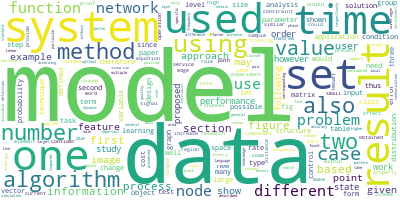

In [21]:
# Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
#long_string = ','.join(list(papers['paper_text_processed'].values))
long_string = ' '.join(word_list)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
#wordcloud.generate(long_string)
#wordcloud.generate(word_list)
wordcloud.generate_from_frequencies(counter)

# Visualize the word cloud
wordcloud.to_image()

In [ ]:
file_path = cwd + '\\Preprocessed\\'
def process_pdf(file_name, batch_num, start_ind, end_ind, ids):
    textdf = read_pdf(file_name, start_ind, end_ind, ids)
    save_path = file_path + str(batchnum)
    output = clean_pdf(textdf, save_path)
    

In [66]:
def process_batch(batch_ind, batch_size=50000, field='Computer Science'):
    file_name_meta = '20200705v1/full/metadata/metadata_' + str(batch_ind) + '.jsonl'
    file_name_pdf = '20200705v1/full/pdf_parses/pdf_parses_' + str(batch_ind) + '.jsonl'
    
    import os
    cwd = os.getcwd()
    file_path = cwd + '\\Preprocessed\\' 

    start = time.time()
    
    nlines = sum(1 for line in open(file_name_pdf))
    batch_num = int(np.ceil(nlines / batch_size))
    
    print('Processing metadata file', batch_ind)
    selected_data = process_metadata(file_name_meta, field)
    selected_ids = selected_data['ids'].values
    
    with open(file_path+'metadata.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
        pickle.dump(selected_data, f)
    
    t = time.time()
    print(t-start)
    
    for i in range(batch_num):
        print('Processing pdfs batch Number: ', i)
        line_nums = [batch_size*i, batch_size*(i+1)]
        textdf = read_pdf(file_name_pdf,line_nums[0],line_nums[1], ids)  
        
        t = time.time()
        print(t-start)
        
        print('Processing pdfs batch Number: ', i)

        output = clean_pdf(textdf, file_path+str(i))
        
        t = time.time()
        print(t-start)

In [67]:
process_batch(batch_ind=0, field='Computer Science')

Processing metadata file 0
35.497846364974976
Processing pdfs batch Number:  0


TypeError: can only concatenate str (not "int") to str

In [102]:
word_counts = sorted(dct.dfs.items(), key = lambda x: x[1], reverse=True)
top_ids = [x[0] for x in word_counts[0:100]]
top_words = [dct.id2token[x] for x in top_ids]

KeyError: 980

In [ ]:
dct.filter_tokens(bad_ids=top_ids)

## Train LDA model

In [107]:
type(corpus)

list

In [105]:
documents = corpus.get_texts()

AttributeError: 'list' object has no attribute 'get_texts'

In [ ]:
# Step 4: Train the LDA model
from gensim.models import LdaModel, LdaMulticore
from gensim.test.utils import common_corpus

#perplexity_logger = PerplexityMetric(corpus=common_corpus, logger='shell')
#convergence_logger = ConvergenceMetric(logger='shell')
#coherence_cv_logger = CoherenceMetric(corpus=corpus, logger='shell', coherence = 'c_v', texts = documents)

lda_model = LdaMulticore(corpus=corpus,
                         id2word=dct,
                         random_state=2020,
                         num_topics=10,
                         passes=1,
                         chunksize=1000,
                         batch=False,
                         alpha='asymmetric',
                         decay=0.5,
                         offset=64,
                         eta=None,
                         eval_every=0,
                         iterations=100,
                         gamma_threshold=0.001,
                         per_word_topics=True)

# save the model
lda_model.save('lda_model.model')

# See the topics
lda_model.print_topics(-1)

In [84]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -0.6558824017161562


In [76]:
num_topics = 10

top_topics = lda_model.top_topics(corpus) #, num_words=20)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -0.6559.
[([(0.005903978, 'model'),
   (0.0056817126, 'data'),
   (0.0050683604, 'system'),
   (0.004683143, 'one'),
   (0.004589382, 'set'),
   (0.004308348, 'result'),
   (0.004308256, 'time'),
   (0.0041383095, 'used'),
   (0.0041151457, 'using'),
   (0.004082712, 'algorithm'),
   (0.003972761, 'two'),
   (0.0039018418, 'method'),
   (0.0038599866, 'also'),
   (0.0038234273, 'number'),
   (0.0033649916, 'value'),
   (0.0032020246, 'problem'),
   (0.0031827844, 'case'),
   (0.003104415, 'function'),
   (0.0029815945, 'use'),
   (0.0029531042, 'different')],
  -0.15817686393398864),
 ([(0.00148182, 'method'),
   (0.0013913988, 'ship'),
   (0.001329745, 'model'),
   (0.0010342445, 'set'),
   (0.001012543, 'user'),
   (0.0009968651, 'data'),
   (0.0008815918, 'one'),
   (0.00087165734, 'system'),
   (0.0008399095, 'using'),
   (0.00083453057, 'used'),
   (0.000791407, 'function'),
   (0.0007810815, 'algorithm'),
   (0.00077615393, 'value'),
   (0.0007526579, 'pr